In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events

In [4]:
%matplotlib notebook

#### Functions

In [5]:
# get units (either 'single', 'mua', or 'all') and peak channel
def get_units(plot_group, cluster_groups_path, cluster_metrics_path):
    # get list of unit ids
    cluster_group = pd.read_csv(cluster_groups_path, sep='\t')
    
    if plot_group == 'single':
        cluster_ids = cluster_group[cluster_group['group'] == 'good'].cluster_id.values
    elif plot_group == 'mua':
        cluster_ids = cluster_group[cluster_group['group'] == 'mua'].cluster_id.values
    elif plot_group == 'all':
        cluster_ids = cluster_group[cluster_group['group'] != 'noise'].cluster_id.values
    
    # find peak channel for units
    cluster_metrics = pd.read_csv(exp.ephys_params[plot_probe]['cluster_metrics'], index_col=0)
    cluster_peak_chs = cluster_metrics[cluster_metrics['cluster_id'].isin(cluster_ids)].peak_channel.values
    
    return cluster_ids, cluster_peak_chs

### Define data path

In [6]:
rec_folder = r'F:\EEG_exp\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.


In [7]:
plot_probe = 'probeB'

#### Load stim table

In [8]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep
0,biphasic,80,33.63939,33.63999,0.0004,0
1,biphasic,80,37.74180,37.74240,0.0004,0
2,biphasic,80,41.50520,41.50580,0.0004,0
3,biphasic,80,45.65971,45.66031,0.0004,0
4,biphasic,80,49.84935,49.84996,0.0004,0


#### Select units and get peak channel for each

In [9]:
choose_unit_quality = 'single' # if 'single', selects only good single units; if 'all', selects single and 'mua' units
# if 'mua', selects only 'mua' units

select_units, peak_chs = get_units(choose_unit_quality, exp.ephys_params[plot_probe]['cluster_group'], exp.ephys_params[plot_probe]['cluster_metrics'])
print(len(select_units))
print(len(peak_chs))

215
215


In [10]:
sorted_units = select_units[np.squeeze(np.argsort(peak_chs))]

In [11]:
print(select_units[0:10])
print(sorted_units[0:10])
# print(peak_chs[0:10])

[11 20 31 32 37 39 42 43 46 56]
[429 636 427  11 431 541  20  32 703  31]


#### Parameters for plotting

In [12]:
# plot_type = 'ap' # 'ap' or 'lfp'
# plot_chunk = 20 # number of channels per plot
plot_before = 0.5 # time before event, s
plot_after = 1 # time after event, s
plot_event = 'stim' # 'spont' or 'stim'

## if plot_event == 'spont'
spont_time = 50 # time in minutes to plot around if spont is chosen
## if plot_event == 'stim'
event_ind = 20 # stim_event time to choose, must be integer
stim_type = 'fullscreen' # 'fullscreen', 'auditory', 'biphasic'
stim_amp = 'white' # current amplitude = [20, 50, 70, 100]
stim_sweep = 0 # look at an event during chosen sweep, int between 0 and 9?

In [13]:
if plot_event == 'spont':
    plot_time = spont_time*60 # this value should be in seconds now
elif plot_event == 'stim':
    stim_times = get_stim_events(stim_log, stim_type, stim_amp, stim_sweep)
    plot_time = stim_times[event_ind] # this value should be in seconds

#### Working with spike times and clusters

In [14]:
spike_times = np.load(exp.ephys_params[plot_probe]['spike_times'])
spike_clusters = np.load(exp.ephys_params[plot_probe]['spike_clusters'])

In [15]:
units_raster = []

for uniti in sorted_units:
    spikesi = np.squeeze(spike_times[spike_clusters == uniti])

    spikei_inds = np.squeeze(np.argwhere((spikesi > plot_time-plot_before) & (spikesi < plot_time+plot_after)))
    units_raster.append(spikesi[spikei_inds])

In [16]:
print(np.shape(units_raster))
# print(len(units_raster[70]))

(215,)


### Raster for all units

<IPython.core.display.Javascript object>


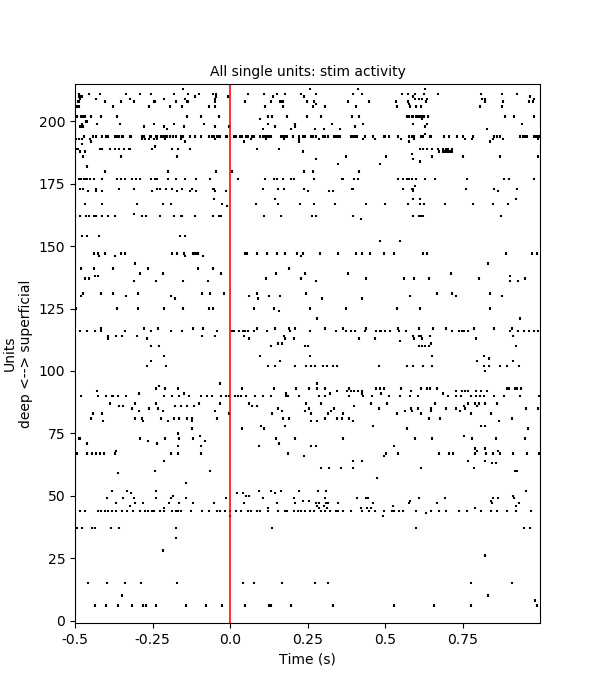

In [17]:
fig, ax = plt.subplots(figsize=(6,7))
for indi, spikes in enumerate(units_raster):
    ax.eventplot([spikes], lineoffsets=indi, linelengths=0.95, color='black')
ax.set_xlim([plot_time-plot_before, plot_time+plot_after])
ax.set_ylim([-1, indi+1])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Units\ndeep <--> superficial')
ax.set_title('All %s units: %s activity' % (choose_unit_quality, plot_event))
if plot_event == 'stim':
    ax.axvline(plot_time, color='r', alpha=0.8)
    ax.set_xticks(np.arange(plot_time-plot_before, plot_time+plot_after, 0.25))
    ax.set_xticklabels(np.arange(-plot_before, plot_after, 0.25))

In [18]:
print(ax.get_xticks())
print(ax.get_xticklabels())

[604.24479 604.49479 604.74479 604.99479 605.24479 605.49479]
<a list of 6 Text xticklabel objects>
